# Men's NCAA Tournament Prediction: Model Comparison and Brier Score Optimization

This notebook explores various machine learning models to predict outcomes in the Men's NCAA Basketball Tournament. Our primary goal, as with the women's tournament analysis, is to optimize the Brier score, a metric that evaluates the accuracy of probabilistic predictions.

We experiment with the following models:

* **XGB Survival Model:** A survival analysis approach to predict the time-to-event (tournament progression).
* **XGB Classifier:** A gradient boosting classifier for direct game outcome prediction.
* **Extra Trees Classifier:** An ensemble method utilizing multiple randomized decision trees.
* **Support Vector Machine (SVM) Models:** Utilizing different kernels and feature sets.
    * **Including GNN Embeddings:** We train a Graph Neural Network (GNN) and utilize its generated embeddings as additional features in the SVM classifier.
    * **Including KMeans Clustering:** We incorporate KMeans clustering to create a categorical feature representing cluster assignments.

To ensure robust evaluation and minimize overfitting, we employ cross-validation. Specifically, each model is trained and evaluated using 5 distinct test sets, where each test set encompasses three consecutive tournament seasons. This cross-validation strategy provides a comprehensive assessment of model performance across diverse time periods.

The notebook focuses on fine-tuning model parameters and feature sets, including GNN embeddings and KMeans clustering, to minimize the Brier score, ultimately aiming to achieve the most accurate probabilistic predictions for Men's NCAA Tournament outcomes. **However, unlike the women's tournament analysis, this investigation revealed that a different model, GNN Enhanced XGB Classifier, achieved the best results. The following sections will detail the findings and the specific configurations that contributed to this model's superior performance.**

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, brier_score_loss
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from lifelines.utils import concordance_index
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
import xgboost as xgb
import torch
import torch_geometric.data
import torch_geometric.nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import itertools
import csv
import warnings
from sklearn.neighbors import NearestNeighbors
import os
from scripts import modeling_functions as mf

# Set a seed value (you can choose any integer)
seed_value = 42

# Set seed for NumPy
np.random.seed(seed_value)

# Set seed for PyTorch
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)  # if you are using multi-GPU.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#4. Set seed for os environment variables.
os.environ['PYTHONHASHSEED'] = str(seed_value)


warnings.filterwarnings('ignore')
training_data=pd.read_csv('data/processed/mens_processed_data.csv')
training_data=pd.get_dummies(training_data,columns=['Reg_ConfAbbrev','Opponent_reg_ConfAbbrev'])
training_data.head()

,Game_ID,Season,DayNum,Game_Score,Game_Loc,Game_FGM,Game_FGA,Game_FGM3,Game_FGA3,Game_FTM,...,Opponent_reg_ConfAbbrev_pac_twelve,Opponent_reg_ConfAbbrev_patriot,Opponent_reg_ConfAbbrev_sec,Opponent_reg_ConfAbbrev_southern,Opponent_reg_ConfAbbrev_southland,Opponent_reg_ConfAbbrev_summit,Opponent_reg_ConfAbbrev_sun_belt,Opponent_reg_ConfAbbrev_swac,Opponent_reg_ConfAbbrev_wac,Opponent_reg_ConfAbbrev_wcc
0,0,2003,134,92,N,32,69,11,29,17,...,False,False,False,False,False,False,False,True,False,False
1,1,2003,136,80,N,31,66,7,23,11,...,False,False,False,False,False,False,False,False,False,False
2,2,2003,136,84,N,31,59,6,14,16,...,False,False,False,False,False,False,False,False,False,False
3,3,2003,136,79,N,29,53,3,7,18,...,False,False,False,False,False,False,False,False,False,False
4,4,2003,136,76,N,27,64,7,20,15,...,False,False,False,False,False,False,False,False,False,False


# Modeling
- Cross Validated Test Set: each model is evaluated by its average brier_score across 5 different test sets, each containing three seasons.

# Survival Analysis Model
- Event column: Represents the team losing in the tournament
- Event Time column: Represents the DayNum when the team experienced the loss.

In [3]:
model_dict = {}  # Initialize a dictionary to store model performance metrics (Brier scores).

warnings.filterwarnings('ignore')  # Suppress warning messages for cleaner output.

add_features = ['Opponent_reg_Wins']  # Define additional features to include in the model.

# Define columns with null values that should be excluded from the feature set.
cols_with_nulls = [
    'Opponent_reg_LatestOrdinalRank_SAG', 'Reg_LatestOrdinalRank_SAG', 'Reg_LatestOrdinalRank_WOL',
    'Opponent_reg_LatestOrdinalRank_WOL', 'Opponent_reg_LatestOrdinalRank_SAG', 'Opponent_reg_LatestOrdinalRank_WOL'
]

# Create a list of difference features, excluding conference differences.
features = [col for col in training_data.columns if 'Diff' in col]
features = [col for col in features if 'Conf' not in col]

# Add ordinal ranking features to the feature set, ensuring no duplicates.
features = list(set(features + [col for col in training_data.columns if 'Ordinal' in col]))

# Add 'Reg_Wins' and 'Reg_Score' to the feature set.
features = features + ['Reg_Wins', 'Reg_Score']

# Filter out null-containing columns and add additional features.
features = [col for col in features if col not in cols_with_nulls] + add_features

# Define test seasons for cross-validation. Each sublist represents a set of seasons for testing.
test_seasons = [
    [2022, 2023, 2024], [2017, 2018, 2019], [2014, 2015, 2016], [2010, 2011, 2012], [2012, 2013, 2014]
]

# Create a set of unique features to use during training.
FEATURES = list(set(features))

# Initialize lists to store survival model accuracies and Brier scores.
survival_accuracies = []
brier_scores = []

# Iterate through each set of test seasons for cross-validation.
for T_season in test_seasons:
    # Split the training data into train and test sets based on the current test seasons.
    train, test = mf.preprocess_time_split(training_data, T_season)

    # Fit the XGB Survival model and generate risk scores.
    xgb_survival, test, risk_scores = mf.fit_xg_survival_model(
        train, test, FEATURES, show_importance=False, max_depth=4, learning_rate=0.3,subsample=0.8,n_estimators=300
    )

    # Evaluate the model's accuracy and Brier score.
    accuracy, brier = mf.evaluate_accuracy(test)

    # Append the accuracy and Brier score to their respective lists.
    survival_accuracies.append(accuracy)
    brier_scores.append(brier)

# Calculate the mean accuracy and Brier score across all test seasons.
mean_survival_accuracy = np.array(survival_accuracies).mean()
mean_brier = np.array(brier_scores).mean()

# Store the mean Brier score in the model_dict with the 'Survival' key.
model_dict['Survival'] = mean_brier

# Print the average accuracy and Brier score for the survival model.
print('Average Accuracy: Survival: ', mean_survival_accuracy)
print('Average Brier: Survival: ', mean_brier)

Concordance Index: 0.773
Concordance Index: 0.812
Concordance Index: 0.789
Concordance Index: 0.792
Concordance Index: 0.807
Average Accuracy: Survival:  0.6785315845017338
Average Brier: Survival:  0.2115589011981624


# Baseline XGB Classifier
- Since we already have the column 'efs' which represents a loss, we will build a classifier to predict whether a team loses or not.

In [4]:
# Define test seasons for cross-validation. Each sublist represents a set of seasons for testing.
test_seasons = [
    [2022, 2023, 2024], [2017, 2018, 2019], [2014, 2015, 2016], [2010, 2011, 2012], [2012, 2013, 2014]
]

# Initialize lists to store classifier accuracies and Brier scores.
classifier_accuracies = []
brier_scores = []

# Iterate through each set of test seasons for cross-validation.
for T_season in test_seasons:
    # Split the training data into train and test sets based on the current test seasons.
    train, test = mf.preprocess_time_split(training_data, T_season)

    # Create a set of unique features to use during training.
    FEATURES = list(set(features))

    # Fit the XGBoost classifier with specified hyperparameters.
    xgb_classifier, _, accuracy_classifier = mf.fit_xgboost_classifier(
        train, test, FEATURES, print_details=False, max_depth=6, learning_rate=0.3, gamma=0.0,
        subsample=1, colsample_bytree=1, n_estimators=100
    )

    # Append the classifier accuracy to the list.
    classifier_accuracies.append(accuracy_classifier)

    # Calculate the Brier score using the trained classifier and test data.
    brier = mf.brier_scorer(xgb_classifier, test[FEATURES], test['efs'])

    # Append the Brier score to the list.
    brier_scores.append(brier)

# Calculate the mean classifier accuracy across all test seasons.
mean_classifier_accuracy = np.array(classifier_accuracies).mean()

# Calculate the mean Brier score across all test seasons and negate it (likely due to a sign convention in mf.brier_scorer).
mean_brier = -np.array(brier_scores).mean()

# Print the average accuracy and Brier score for the classifier.
print('Average Accuracy Classifier: ', mean_classifier_accuracy)
print('Average Brier Classifier: ', mean_brier)

# Store the mean Brier score in the model_dict with the 'XGB_Classifier_Baseline' key.
model_dict['XGB_Classifier_Baseline'] = mean_brier

Accuracy: 0.654
Precision: 0.655
Recall: 0.652
F1 Score: 0.653
ROC AUC: 0.732
Concordance Index (using predicted probabilities): 0.656
Accuracy: 0.704
Precision: 0.697
Recall: 0.721
F1 Score: 0.709
ROC AUC: 0.786
Concordance Index (using predicted probabilities): 0.680
Accuracy: 0.662
Precision: 0.668
Recall: 0.642
F1 Score: 0.655
ROC AUC: 0.728
Concordance Index (using predicted probabilities): 0.674
Accuracy: 0.652
Precision: 0.650
Recall: 0.657
F1 Score: 0.653
ROC AUC: 0.729
Concordance Index (using predicted probabilities): 0.642
Accuracy: 0.674
Precision: 0.679
Recall: 0.662
F1 Score: 0.670
ROC AUC: 0.750
Concordance Index (using predicted probabilities): 0.670
Average Accuracy Classifier:  0.6691090004522839
Average Brier Classifier:  0.24080903500292777


# Hyperparameter Search

In [5]:
rerun=False
if rerun:
    mf.manual_grid_search_xgb_brier(training_data, list(set(features)),mode='w')
else:
    grid_search_df=pd.read_csv('data/processed/grid_search_brier.csv')
    print(grid_search_df.sort_values(by='brier_score').head().to_markdown())

|     |   max_depth |   subsample |   colsample_bytree |   n_estimators |   gamma |   learning_rate |   brier_score |
|----:|------------:|------------:|-------------------:|---------------:|--------:|----------------:|--------------:|
| 195 |           3 |         0.8 |                0.9 |            300 |     0.2 |            0.01 |      0.195917 |
| 192 |           3 |         0.8 |                0.9 |            300 |     0.1 |            0.01 |      0.195917 |
| 189 |           3 |         0.8 |                0.9 |            300 |     0   |            0.01 |      0.195917 |
| 171 |           3 |         0.8 |                0.8 |            300 |     0   |            0.01 |      0.19622  |
| 174 |           3 |         0.8 |                0.8 |            300 |     0.1 |            0.01 |      0.196221 |


### XGB Classifier with optimized parameters

In [6]:
test_seasons=[[2022, 2023, 2024], [2017, 2018, 2019], [2014, 2015, 2016], [2010, 2011, 2012], [2012, 2013, 2014]]

classifier_accuracies=[]
brier_scores=[]
for T_season in test_seasons:
    train,test=mf.preprocess_time_split(training_data, T_season)  
    FEATURES=list(set(features))
    xgb_classifier,_,accuracy_classifier=mf.fit_xgboost_classifier(train, test,FEATURES,print_details=False,max_depth=3,learning_rate=0.01,gamma=0.1,subsample=0.8,colsample_bytree=0.9,n_estimators=300)
    classifier_accuracies.append(accuracy_classifier)
    brier=mf.brier_scorer(xgb_classifier, test[FEATURES], test['efs'])
    brier_scores.append(brier)
mean_classifier_accuracy=np.array(classifier_accuracies).mean()

mean_brier=-np.array(brier_scores).mean()
print('Average Accuracy: Classifier: ', mean_classifier_accuracy)
print('Average Brier: Classifier: ', mean_brier)
model_dict['XGB_Classifier_OptParam']=mean_brier


Accuracy: 0.672
Precision: 0.672
Recall: 0.672
F1 Score: 0.672
ROC AUC: 0.742
Concordance Index (using predicted probabilities): 0.658
Accuracy: 0.736
Precision: 0.741
Recall: 0.726
F1 Score: 0.734
ROC AUC: 0.808
Concordance Index (using predicted probabilities): 0.708
Accuracy: 0.704
Precision: 0.705
Recall: 0.701
F1 Score: 0.703
ROC AUC: 0.769
Concordance Index (using predicted probabilities): 0.681
Accuracy: 0.669
Precision: 0.667
Recall: 0.677
F1 Score: 0.672
ROC AUC: 0.750
Concordance Index (using predicted probabilities): 0.662
Accuracy: 0.659
Precision: 0.660
Recall: 0.657
F1 Score: 0.658
ROC AUC: 0.762
Concordance Index (using predicted probabilities): 0.666
Average Accuracy: Classifier:  0.6880672395597769
Average Brier: Classifier:  0.1961775551307693


# Graph Neural Network
- Fit GNN model and use embeddings as features in the xgb model

In [7]:
gnn_features = [
    'Reg_Score',
    'Reg_NumOT',
    'Reg_FGM',
    'Reg_FGA',
    'Reg_FGM3',
    'Reg_FGA3',
    'Reg_FTM',
    'Reg_FTA',
    'Reg_OR',
    'Reg_DR',
    'Reg_Ast',
    'Reg_TO',
    'Reg_Stl',
    'Reg_Blk',
    'Reg_PF',
    'Reg_Wins',
    'Reg_Losses',
    'Reg_AverageOrdinalRank',
    'Reg_LatestOrdinalRank_POM',
    'Reg_Momentum',
    'Reg_First_Four',
    'Reg_Region_W',
    'Reg_Region_X',
    'Reg_Region_Y',
    'Reg_Region_Z',
    'Reg_ConfAbbrev_a_sun',
    'Reg_ConfAbbrev_a_ten',
    'Reg_ConfAbbrev_aac',
    'Reg_ConfAbbrev_acc',
    'Reg_ConfAbbrev_aec',
    'Reg_ConfAbbrev_big_east',
    'Reg_ConfAbbrev_big_sky',
    'Reg_ConfAbbrev_big_south',
    'Reg_ConfAbbrev_big_ten',
    'Reg_ConfAbbrev_big_twelve',
    'Reg_ConfAbbrev_big_west',
    'Reg_ConfAbbrev_caa',
    'Reg_ConfAbbrev_cusa',
    'Reg_ConfAbbrev_horizon',
    'Reg_ConfAbbrev_ivy',
    'Reg_ConfAbbrev_maac',
    'Reg_ConfAbbrev_mac',
    'Reg_ConfAbbrev_meac',
    'Reg_ConfAbbrev_mid_cont',
    'Reg_ConfAbbrev_mvc',
    'Reg_ConfAbbrev_mwc',
    'Reg_ConfAbbrev_nec',
    'Reg_ConfAbbrev_ovc',
    'Reg_ConfAbbrev_pac_ten',
    'Reg_ConfAbbrev_pac_twelve',
    'Reg_ConfAbbrev_patriot',
    'Reg_ConfAbbrev_sec',
    'Reg_ConfAbbrev_southern',
    'Reg_ConfAbbrev_southland',
    'Reg_ConfAbbrev_summit',
    'Reg_ConfAbbrev_sun_belt',
    'Reg_ConfAbbrev_swac',
    'Reg_ConfAbbrev_wac',
    'Reg_ConfAbbrev_wcc',
    'Opponent_reg_Score',
    'Opponent_reg_NumOT',
    'Opponent_reg_FGM',
    'Opponent_reg_FGA',
    'Opponent_reg_FGM3',
    'Opponent_reg_FGA3',
    'Opponent_reg_FTM',
    'Opponent_reg_FTA',
    'Opponent_reg_OR',
    'Opponent_reg_DR',
    'Opponent_reg_Ast',
    'Opponent_reg_TO',
    'Opponent_reg_Stl',
    'Opponent_reg_Blk',
    'Opponent_reg_PF',
    'Opponent_reg_Wins',
    'Opponent_reg_Losses',
    'Opponent_reg_Momentum',
    'Opponent_reg_Region_W',
    'Opponent_reg_Region_X',
    'Opponent_reg_Region_Y',
    'Opponent_reg_Region_Z',
    'Opponent_reg_ConfAbbrev_a_sun',
    'Opponent_reg_ConfAbbrev_a_ten',
    'Opponent_reg_ConfAbbrev_aac',
    'Opponent_reg_ConfAbbrev_acc',
    'Opponent_reg_ConfAbbrev_aec',
    'Opponent_reg_ConfAbbrev_big_east',
    'Opponent_reg_ConfAbbrev_big_sky',
    'Opponent_reg_ConfAbbrev_big_south',
    'Opponent_reg_ConfAbbrev_big_ten',
    'Opponent_reg_ConfAbbrev_big_twelve',
    'Opponent_reg_ConfAbbrev_big_west',
    'Opponent_reg_ConfAbbrev_caa',
    'Opponent_reg_ConfAbbrev_cusa',
    'Opponent_reg_ConfAbbrev_horizon',
    'Opponent_reg_ConfAbbrev_ivy',
    'Opponent_reg_ConfAbbrev_maac',
    'Opponent_reg_ConfAbbrev_mac',
    'Opponent_reg_ConfAbbrev_meac',
    'Opponent_reg_ConfAbbrev_mid_cont',
    'Opponent_reg_ConfAbbrev_mvc',
    'Opponent_reg_ConfAbbrev_mwc',
    'Opponent_reg_ConfAbbrev_nec',
    'Opponent_reg_ConfAbbrev_ovc',
    'Opponent_reg_ConfAbbrev_pac_ten',
    'Opponent_reg_ConfAbbrev_pac_twelve',
    'Opponent_reg_ConfAbbrev_patriot',
    'Opponent_reg_ConfAbbrev_sec',
    'Opponent_reg_ConfAbbrev_southern',
    'Opponent_reg_ConfAbbrev_southland',
    'Opponent_reg_ConfAbbrev_summit',
    'Opponent_reg_ConfAbbrev_sun_belt',
    'Opponent_reg_ConfAbbrev_swac',
    'Opponent_reg_ConfAbbrev_wac',
    'Opponent_reg_ConfAbbrev_wcc',
]

gnn_features=[col for col in gnn_features if col in training_data.columns]

train, test= mf.preprocess_time_split(training_data, test_seasons=[2022, 2023,2024])
# Split the training data into training and validation sets based on seasons
train_df, val_df = mf.preprocess_time_split(train, test_seasons=[2019, 2021])

# Convert boolean features to float
for col in gnn_features:
    if train_df[col].dtype == 'bool':
        train_df[col] = train_df[col].astype(float)
    if val_df[col].dtype == 'bool':
        val_df[col] = val_df[col].astype(float)
    if test[col].dtype=='bool':
        test[col] = test[col].astype(float)
k=4

# Create graphs for training and validation sets
train_edge_index = mf.create_graph(train_df, gnn_features, k=k)
val_edge_index = mf.create_graph(val_df, gnn_features, k=k)

# Create torch_geometric.data.Data objects
train_data = torch_geometric.data.Data(x=torch.tensor(train_df[gnn_features].values, dtype=torch.float), edge_index=train_edge_index)
val_data = torch_geometric.data.Data(x=torch.tensor(val_df[gnn_features].values, dtype=torch.float), edge_index=val_edge_index)

# Initialize and train GraphSAGE with Dropout
in_channels = len(gnn_features)
hidden_channels = 256
out_channels = 32
dropout_rate = 0.5
weight_decay = 5e-4  # L2 regularization
epochs=1200

model = mf.GraphSAGEModel(in_channels, hidden_channels, out_channels, dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)

# Training loop with validation
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(train_data.x, train_data.edge_index)
    loss = F.mse_loss(out, train_data.x[:, :out_channels])
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_out = model(val_data.x, val_data.edge_index)
        val_loss = F.mse_loss(val_out, val_data.x[:, :out_channels])
        if epoch%300==0:
            print(f"Epoch {epoch + 1}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}")
        if val_loss<2:
            print(f"Epoch {epoch + 1}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}")
    model.train()

# 3. Embedding Extraction
model.eval()
train_embeddings = model(train_data.x, train_data.edge_index).detach().numpy()
val_embeddings = model(val_data.x, val_data.edge_index).detach().numpy()

# 4. Feature Augmentation
train_embedding_df = pd.DataFrame(train_embeddings, columns=[f'gnn_emb_{i}' for i in range(out_channels)])
val_embedding_df = pd.DataFrame(val_embeddings, columns=[f'gnn_emb_{i}' for i in range(out_channels)])

training_data_augmented = pd.concat([train_df.reset_index(drop=True), train_embedding_df], axis=1)
val_dummied_augmented = pd.concat([val_df.reset_index(drop=True), val_embedding_df], axis=1)



test_edge_index = mf.create_graph(test, gnn_features, k=k)
test_data = torch_geometric.data.Data(x=torch.tensor(test[gnn_features].values, dtype=torch.float), edge_index=test_edge_index)
test_embeddings = model(test_data.x, test_data.edge_index).detach().numpy()
test_embedding_df = pd.DataFrame(test_embeddings, columns=[f'gnn_emb_{i}' for i in range(out_channels)])

test_augmented = pd.concat([test.reset_index(drop=True), test_embedding_df], axis=1)

data_augmented = pd.concat([training_data_augmented, val_dummied_augmented, test_augmented])
torch.save(model.state_dict(), "models/gnn_model.pth")  # Save the model's state dictionary
print("GNN model saved to gnn_model.pth")

Epoch 1, Training Loss: 934.5873413085938, Validation Loss: 763.2733764648438
Epoch 301, Training Loss: 10.528900146484375, Validation Loss: 3.935962677001953
Epoch 601, Training Loss: 7.7745137214660645, Validation Loss: 2.882359504699707
Epoch 901, Training Loss: 6.902256011962891, Validation Loss: 2.49198842048645
GNN model saved to gnn_model.pth


# Cross Validate With GNN

In [8]:
# Define test seasons for cross-validation. Each sublist represents a set of seasons for testing.
test_seasons = [
    [2022, 2023, 2024], [2017, 2018, 2019], [2014, 2015, 2016], [2010, 211, 2012], [2012, 2013, 2014]
]

# Initialize lists to store classifier accuracies and Brier scores.
classifier_accuracies = []
brier_scores = []

# Iterate through each set of test seasons for cross-validation.
for T_season in test_seasons:
    # Augment the training data with GNN embeddings.
    train, test = mf.augment_data_with_gnn_embeddings(
        training_data, T_season, gnn_features, hidden_channels=256
    )

    # Extract the GNN embedding features.
    embeddings_features = [col for col in train.columns if 'gnn' in col]

    # Combine regular features with GNN embeddings for the model.
    FEATURES = list(set(features + embeddings_features))

    # Fit the XGBoost classifier with optimized parameters.
    xgb_classifier, _, accuracy_classifier = mf.fit_xgboost_classifier(
        train, test, FEATURES, print_details=False, max_depth=3, learning_rate=0.01, gamma=0.1,
        subsample=0.8, colsample_bytree=0.9, n_estimators=300
    )

    # Append the classifier accuracy to the list.
    classifier_accuracies.append(accuracy_classifier)

    # Calculate the Brier score using the trained classifier and test data.
    brier = mf.brier_scorer(xgb_classifier, test[FEATURES], test['efs'])

    # Append the Brier score to the list.
    brier_scores.append(brier)

# Calculate the mean classifier accuracy across all test seasons.
mean_classifier_accuracy = np.array(classifier_accuracies).mean()

# Calculate the mean Brier score across all test seasons and negate it (due to a sign convention in mf.brier_scorer).
mean_brier = -np.array(brier_scores).mean()

# Print the average accuracy and Brier score for the classifier.
print('Average Accuracy: Classifier: ', mean_classifier_accuracy)
print('Average Brier: Classifier: ', mean_brier)

# Store the mean Brier score in the model_dict with the 'XGB_Classifier_OptParam_GNN' key.
model_dict['XGB_Classifier_OptParam_GNN'] = mean_brier

Epoch 1, Training Loss: 803.9688720703125, Validation Loss: 656.55029296875
Accuracy: 0.679
Precision: 0.680
Recall: 0.677
F1 Score: 0.678
ROC AUC: 0.749
Concordance Index (using predicted probabilities): 0.658
Epoch 1, Training Loss: 796.7005615234375, Validation Loss: 691.0623779296875
Accuracy: 0.726
Precision: 0.736
Recall: 0.706
F1 Score: 0.721
ROC AUC: 0.812
Concordance Index (using predicted probabilities): 0.713
Epoch 1, Training Loss: 937.0672607421875, Validation Loss: 737.0302734375
Accuracy: 0.701
Precision: 0.698
Recall: 0.711
F1 Score: 0.704
ROC AUC: 0.770
Concordance Index (using predicted probabilities): 0.683
Epoch 1, Training Loss: 859.54052734375, Validation Loss: 687.4654541015625
Accuracy: 0.698
Precision: 0.700
Recall: 0.695
F1 Score: 0.697
ROC AUC: 0.783
Concordance Index (using predicted probabilities): 0.677
Epoch 1, Training Loss: 821.5423583984375, Validation Loss: 673.3145141601562
Accuracy: 0.674
Precision: 0.670
Recall: 0.687
F1 Score: 0.678
ROC AUC: 0.761

- The GNN model appears to improve the classifier, albeit slightly.  This is the best result we have seen thus far.

In [9]:
def cross_validated_permutation_importance_seasons(model, data, features, gnn_features, test_seasons_list, target_col='efs', n_repeats=5):
    """
    Cross-validates permutation feature importance using different test seasons.
    """

    for test_seasons in test_seasons_list:
        train_data, test_data = mf.augment_data_with_gnn_embeddings(
            data, test_seasons, gnn_features, hidden_channels=256
        )

        embeddings_features = [col for col in train_data.columns if 'gnn' in col]
        with_embeddings_features = list(set(features + embeddings_features))

        # Initialize the dictionary AFTER creating with_embeddings_features
        feature_importances = {feature: [] for feature in with_embeddings_features}

        X_train = train_data[with_embeddings_features]
        y_train = train_data[target_col]
        X_test = test_data[with_embeddings_features]
        y_test = test_data[target_col]

        model.fit(X_train, y_train)

        fold_importances = mf.permutation_feature_importance_classifier(model, test_data, with_embeddings_features, n_repeats=n_repeats)

        for feature, importance in fold_importances.items():
            feature_importances[feature].append(importance)

    average_importances = {feature: np.mean(importances) for feature, importances in feature_importances.items()}

    return average_importances

# Cross validated Permutation Feature Importance
### &emsp; With GNN embeddings

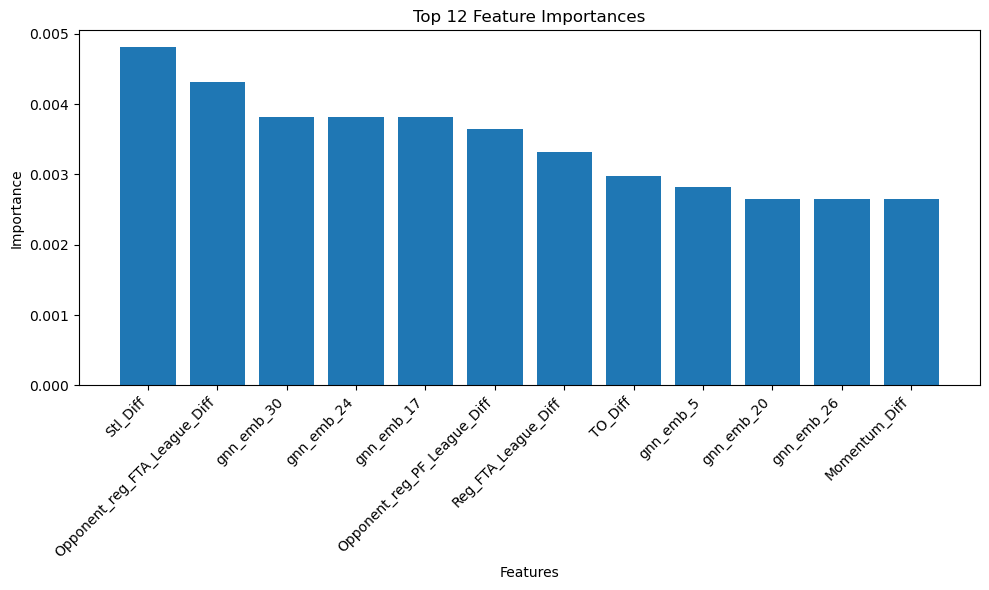

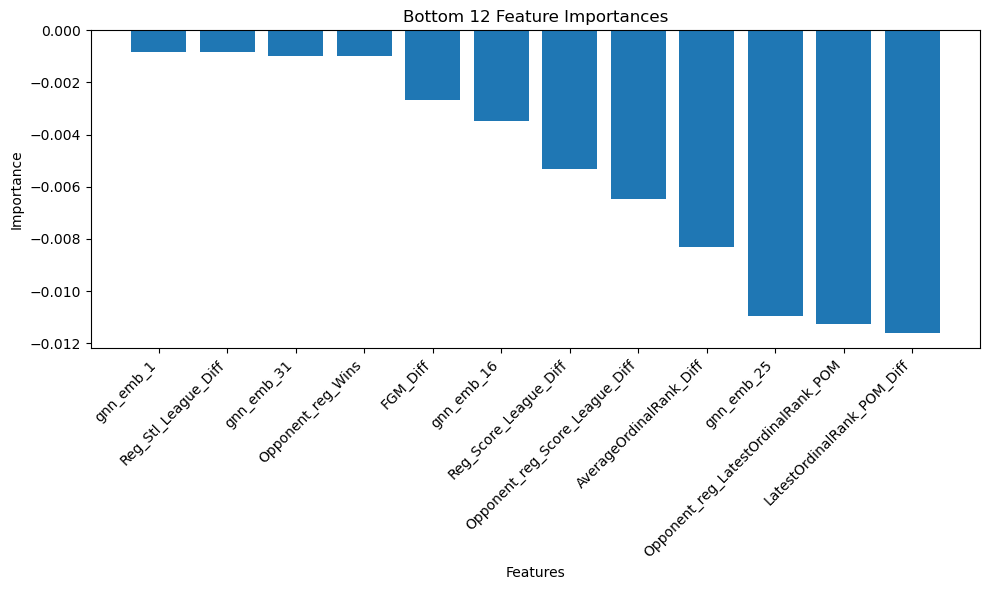

In [10]:
# Includes the GNN embedding features
rerun=False
if rerun:
    xgb_model=xgb.XGBClassifier(n_estimators=300,gamma=0.1,learning_rate=0.01, subsample=0.8, colsample_bytree=0.9,max_depth=3)
    cv_perm_gnn=cross_validated_permutation_importance_seasons(xgb_model, training_data,list(set(features)),gnn_features,test_seasons,n_repeats=15)
    np.save('data/processed/important_features_xgb_gnn.npy',cv_perm)
else:
    cv_perm_gnn=np.load('data/processed/important_features_xgb_gnn.npy',allow_pickle=True).item()
mf.plot_top_bottom_feature_importance(cv_perm_gnn, top_n=12, bottom_n=12)


### Remove Features
- Filter out features that when permuted increase the brier score.

In [11]:
important_features=[col for col in cv_perm_gnn.keys() if cv_perm_gnn[col]>0] # Filter out features that negatively impact performance
classifier_accuracies=[]
brier_scores=[]
for T_season in test_seasons:
    
    train,test=mf.augment_data_with_gnn_embeddings(
            training_data, T_season, gnn_features, hidden_channels=256
        )

    embeddings_features = [col for col in train.columns if 'gnn' in col]
    with_embeddings_features = list(set(features + embeddings_features))
    important_features=[col for col in cv_perm_gnn.keys() if cv_perm_gnn[col]>0] # Filter out features that negatively impact performance
    xgb_classifier,_,accuracy_classifier=mf.fit_xgboost_classifier(train, test,list(set(important_features)),print_details=False,max_depth=3,learning_rate=0.1,gamma=0.1,subsample=0.9,colsample_bytree=0.8,n_estimators=100)
    classifier_accuracies.append(accuracy_classifier)
    brier=mf.brier_scorer(xgb_classifier, test[list(set(important_features))], test['efs'])
    brier_scores.append(brier)
mean_classifier_accuracy=np.array(classifier_accuracies).mean()


mean_brier=-np.array(brier_scores).mean()
print('Average Accuracy: Classifier: ', mean_classifier_accuracy)
print('Average Brier: Classifier: ', mean_brier)
model_dict['XGB_Classifier_OptParam_FeaturesRemoved_GNN']=mean_brier

Epoch 1, Training Loss: 754.3396606445312, Validation Loss: 634.92431640625
Accuracy: 0.692
Precision: 0.704
Recall: 0.662
F1 Score: 0.682
ROC AUC: 0.731
Concordance Index (using predicted probabilities): 0.705
Epoch 1, Training Loss: 875.1741333007812, Validation Loss: 746.394287109375
Accuracy: 0.674
Precision: 0.694
Recall: 0.622
F1 Score: 0.656
ROC AUC: 0.758
Concordance Index (using predicted probabilities): 0.734
Epoch 1, Training Loss: 797.5128784179688, Validation Loss: 637.968017578125
Accuracy: 0.664
Precision: 0.663
Recall: 0.667
F1 Score: 0.665
ROC AUC: 0.748
Concordance Index (using predicted probabilities): 0.713
Epoch 1, Training Loss: 894.9361572265625, Validation Loss: 704.89990234375
Accuracy: 0.634
Precision: 0.640
Recall: 0.611
F1 Score: 0.625
ROC AUC: 0.726
Concordance Index (using predicted probabilities): 0.689
Epoch 1, Training Loss: 928.4087524414062, Validation Loss: 759.242919921875
Accuracy: 0.657
Precision: 0.662
Recall: 0.642
F1 Score: 0.652
ROC AUC: 0.725

### &emsp; With Original Features

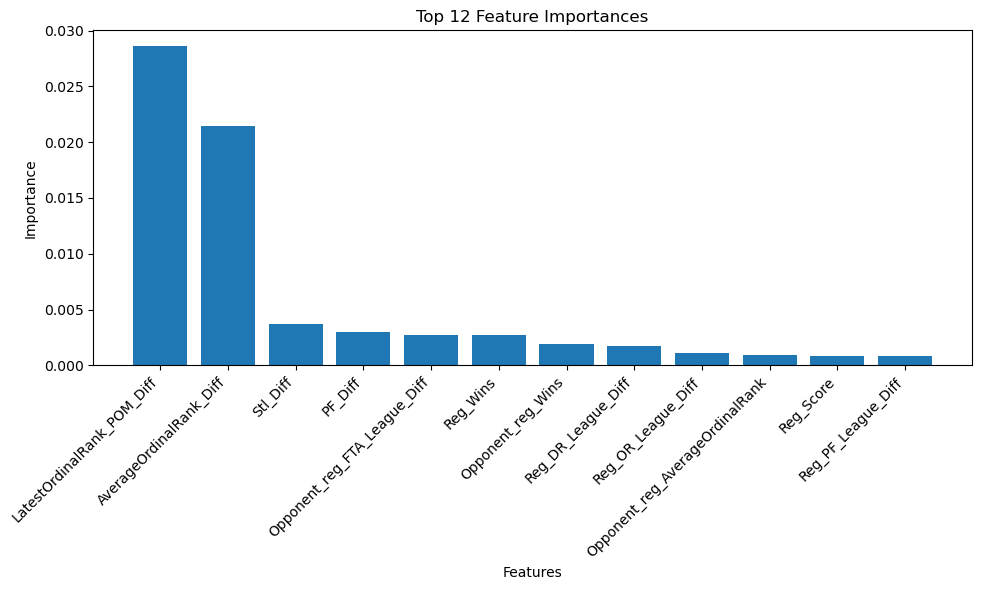

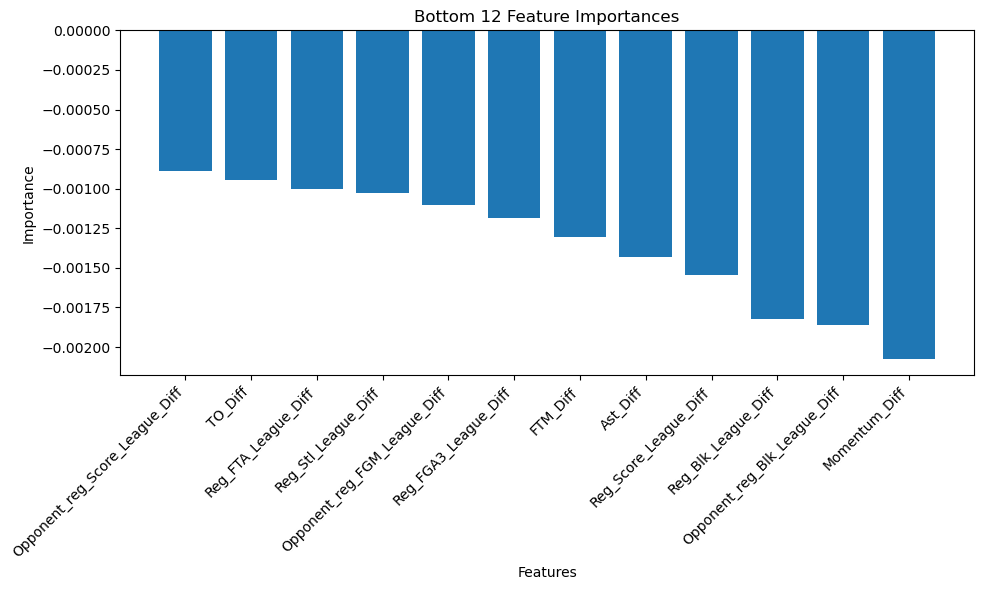

In [12]:
# With the original features
xgb_model=xgb.XGBClassifier(n_estimators=300,gamma=0.1,learning_rate=0.01, subsample=0.8, colsample_bytree=0.9,max_depth=3)
cv_perm=mf.cross_validated_permutation_importance_seasons(xgb_model, training_data,list(set(features)),test_seasons,n_repeats=20)
mf.plot_top_bottom_feature_importance(cv_perm, top_n=12, bottom_n=12)

In [13]:
important_features=[col for col in cv_perm.keys() if cv_perm[col]>0] # Filter out features that negatively impact performance
classifier_accuracies=[]
brier_scores=[]
for T_season in test_seasons:
    
    train,test=mf.preprocess_time_split(training_data, T_season)
    
    xgb_classifier,_,accuracy_classifier=mf.fit_xgboost_classifier(train, test,list(set(important_features)),print_details=False,max_depth=3,learning_rate=0.01,gamma=0.1,subsample=0.9,colsample_bytree=0.8,n_estimators=100)
    classifier_accuracies.append(accuracy_classifier)
    brier=mf.brier_scorer(xgb_classifier, test[list(set(important_features))], test['efs'])
    brier_scores.append(brier)
mean_classifier_accuracy=np.array(classifier_accuracies).mean()


mean_brier=-np.array(brier_scores).mean()
print('Average Accuracy: Classifier: ', mean_classifier_accuracy)
print('Average Brier: Classifier: ', mean_brier)
model_dict['XGB_Classifier_OptParam_FeaturesRemoved']=mean_brier

Accuracy: 0.672
Precision: 0.672
Recall: 0.672
F1 Score: 0.672
ROC AUC: 0.738
Concordance Index (using predicted probabilities): 0.659
Accuracy: 0.724
Precision: 0.723
Recall: 0.726
F1 Score: 0.725
ROC AUC: 0.808
Concordance Index (using predicted probabilities): 0.708
Accuracy: 0.701
Precision: 0.706
Recall: 0.692
F1 Score: 0.698
ROC AUC: 0.769
Concordance Index (using predicted probabilities): 0.681
Accuracy: 0.702
Precision: 0.709
Recall: 0.687
F1 Score: 0.698
ROC AUC: 0.782
Concordance Index (using predicted probabilities): 0.671
Accuracy: 0.679
Precision: 0.678
Recall: 0.682
F1 Score: 0.680
ROC AUC: 0.768
Concordance Index (using predicted probabilities): 0.674
Average Accuracy: Classifier:  0.6956818958641905
Average Brier: Classifier:  0.2024836704748374


**Analysis of Feature Importance:**

"Our feature importance analysis revealed several key insights. Firstly, contrary to expectation, removing features that negatively impacted the Brier score (identified via permutation) did not enhance model performance in either the GNN embedding-enhanced model or the baseline model. This suggests complex interactions between features.

Secondly, the introduction of GNN embeddings dramatically shifted feature importance. In the baseline model, ranking features were dominant. However, with embeddings, they became detrimental, indicating potential redundancy or interference. Notably, the `STL_diff` feature emerged as the most influential in the embedding-enhanced model, a surprising but intriguing outcome that warrants further investigation.

In essence, embedding incorporation altered feature dynamics, highlighting the importance of considering feature interactions rather than relying solely on individual feature importance metrics."

# SVM Classifier

In [14]:
classifier_accuracies=[]
brier_scores=[]
for T_season in test_seasons:
    
    train,test=mf.preprocess_time_split(training_data, T_season)
    
    svm_classifier,test,accuracy_classifier,y_pred_proba=mf.fit_svm_classifier(train, test,list(set(important_features)))
    classifier_accuracies.append(accuracy_classifier)

    brier=mf.brier_score_loss(test['efs'], y_pred_proba) 
    brier_scores.append(brier)
mean_classifier_accuracy=np.array(classifier_accuracies).mean()
mean_brier=np.array(brier_scores).mean()
print('Average Accuracy: Classifier: ', mean_classifier_accuracy)
print('Average Brier: Classifier: ', mean_brier)
model_dict['SVM_Classifier']=mean_brier

Accuracy: 0.682
Precision: 0.685
Recall: 0.672
F1 Score: 0.678
ROC AUC: 0.732
Concordance Index (using predicted probabilities): 0.655
SVMs do not directly provide feature importances.
Accuracy: 0.709
Precision: 0.704
Recall: 0.721
F1 Score: 0.713
ROC AUC: 0.796
Concordance Index (using predicted probabilities): 0.709
SVMs do not directly provide feature importances.
Accuracy: 0.709
Precision: 0.704
Recall: 0.721
F1 Score: 0.713
ROC AUC: 0.788
Concordance Index (using predicted probabilities): 0.697
SVMs do not directly provide feature importances.
Accuracy: 0.676
Precision: 0.677
Recall: 0.672
F1 Score: 0.674
ROC AUC: 0.747
Concordance Index (using predicted probabilities): 0.646
SVMs do not directly provide feature importances.
Accuracy: 0.701
Precision: 0.698
Recall: 0.711
F1 Score: 0.704
ROC AUC: 0.760
Concordance Index (using predicted probabilities): 0.667
SVMs do not directly provide feature importances.
Average Accuracy: Classifier:  0.6953135087919182
Average Brier: Classifier

- The svm provides a good brier_score rivaling the xgb models.

# Extra Trees Classifier

In [15]:
classifier_accuracies=[]
brier_scores=[]
for T_season in test_seasons:
    train,test=mf.preprocess_time_split(training_data, T_season)
    xtrees_classifier,test,accuracy_classifier,y_pred_proba=mf.fit_extra_trees_classifier(train, test,list(set(important_features)),max_depth=None,min_samples_split=2,n_estimators=300,print_details=False)
    classifier_accuracies.append(accuracy_classifier)

    brier=brier_score_loss(test['efs'], y_pred_proba) 
    brier_scores.append(brier)
mean_classifier_accuracy=np.array(classifier_accuracies).mean()
mean_brier=np.array(brier_scores).mean()
print('Average Accuracy: Classifier: ', mean_classifier_accuracy)
print('Average Brier: Classifier: ', mean_brier)
model_dict['ExtraTrees_Classifier']=mean_brier

Accuracy: 0.687
Precision: 0.687
Recall: 0.687
F1 Score: 0.687
ROC AUC: 0.736
Concordance Index (using predicted probabilities): 0.665
Accuracy: 0.719
Precision: 0.718
Recall: 0.721
F1 Score: 0.720
ROC AUC: 0.800
Concordance Index (using predicted probabilities): 0.704
Accuracy: 0.682
Precision: 0.682
Recall: 0.682
F1 Score: 0.682
ROC AUC: 0.771
Concordance Index (using predicted probabilities): 0.684
Accuracy: 0.691
Precision: 0.684
Recall: 0.710
F1 Score: 0.697
ROC AUC: 0.767
Concordance Index (using predicted probabilities): 0.661
Accuracy: 0.667
Precision: 0.663
Recall: 0.677
F1 Score: 0.670
ROC AUC: 0.751
Concordance Index (using predicted probabilities): 0.665
Average Accuracy: Classifier:  0.6889142075880141
Average Brier: Classifier:  0.19711033830001815


# Add Cluster as a feature (Kmeans)

In [16]:
classifier_accuracies=[]
brier_scores=[]
for T_season in test_seasons:
    
    train,test=mf.preprocess_time_split(training_data, T_season)
    train,test=mf.add_kmeans_clusters_train_test(train, test, gnn_features, n_clusters=2, random_state=42)
    
    xgb_classifier,_,accuracy_classifier=mf.fit_xgboost_classifier(train, test,list(set(important_features+['kmeans_cluster'])),print_details=False,max_depth=3,learning_rate=0.1,gamma=0.1,subsample=0.9,colsample_bytree=0.8,n_estimators=100)
    
    classifier_accuracies.append(accuracy_classifier)
    brier=mf.brier_scorer(xgb_classifier, test[list(set(important_features+['kmeans_cluster']))], test['efs'])
    brier_scores.append(brier)
mean_classifier_accuracy=np.array(classifier_accuracies).mean()


mean_brier=-np.array(brier_scores).mean()
print('Average Accuracy: Classifier: ', mean_classifier_accuracy)
print('Average Brier: Classifier: ', mean_brier)
model_dict['XGB_Classifier_RemovedFeatures_Kmeans']=mean_brier

Accuracy: 0.689
Precision: 0.688
Recall: 0.692
F1 Score: 0.690
ROC AUC: 0.742
Concordance Index (using predicted probabilities): 0.662
Accuracy: 0.744
Precision: 0.740
Recall: 0.751
F1 Score: 0.746
ROC AUC: 0.816
Concordance Index (using predicted probabilities): 0.706
Accuracy: 0.699
Precision: 0.694
Recall: 0.711
F1 Score: 0.703
ROC AUC: 0.764
Concordance Index (using predicted probabilities): 0.683
Accuracy: 0.706
Precision: 0.714
Recall: 0.687
F1 Score: 0.700
ROC AUC: 0.771
Concordance Index (using predicted probabilities): 0.662
Accuracy: 0.704
Precision: 0.697
Recall: 0.721
F1 Score: 0.709
ROC AUC: 0.766
Concordance Index (using predicted probabilities): 0.665
Average Accuracy: Classifier:  0.7083855531502792
Average Brier: Classifier:  0.19559110803640628


# SVM Performance Optimization via Grid Search
- Given the potential for improvement in SVM classifier performance, hyperparameter grid search was performed for both the original and embedding-enhanced models.

In [17]:

def manual_grid_search_svm_brier(data, features,gnn_features, target_col='efs', mode='a', output_csv='svm_grid_search_brier.csv', test_seasons=[[2022, 2023, 2024], [2017, 2018, 2019], [2014, 2015, 2016], [2010, 2011, 2012], [2012, 2013, 2014]]):
    """Performs manual grid search for SVM classifier with Brier score and custom test seasons."""


    param_grid = {
        'C': [1,.9,0.1, 10],
        'kernel': ['rbf'],
        'gamma': [.01,'scale', 'auto', 0.1, 1],  # Added 0.01 to gamma
        'probability': [True]
    }

    param_keys = list(param_grid.keys())
    param_values = list(param_grid.values())

    param_combinations = list(itertools.product(*param_values))

    results = []

    for params in param_combinations:
        param_dict = dict(zip(param_keys, params))
        fold_brier_scores = []

        for seasons in test_seasons:
            train,test=mf.augment_data_with_gnn_embeddings(
            data, seasons, gnn_features, hidden_channels=256
        )

            embeddings_features = [col for col in train.columns if 'gnn' in col]
            with_embeddings_features = list(set(features + embeddings_features))
            X_train=train[with_embeddings_features]
            y_train=train[target_col]
            X_test=test[with_embeddings_features]
            y_test=test[target_col]
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            svm_model = SVC(random_state=42, **param_dict)
            svm_model.fit(X_train_scaled, y_train)
            y_pred_proba = svm_model.predict_proba(X_test_scaled)[:, 1]
            brier = brier_score_loss(y_test, y_pred_proba)
            fold_brier_scores.append(brier)

        average_brier = np.mean(fold_brier_scores)
        results.append((param_dict, average_brier))
        print(params)
        print(average_brier)

    best_params, best_brier = min(results, key=lambda x: x[1])

    print("Best Parameters:", best_params)
    print("Best Brier Score:", best_brier)

    with open(output_csv, mode, newline='') as csvfile:
        fieldnames = param_keys + ['brier_score']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        if mode == 'w':
            writer.writeheader()
        for params, brier in results:
            row = params.copy()
            row['brier_score'] = brier
            writer.writerow(row)

    best_svm_model = SVC(random_state=42, **best_params)

    return best_svm_model
rerun=False
if rerun:
    best_svm_model=manual_grid_search_svm_brier(training_data, features,gnn_features,output_csv='svm_grid_search_brier_gnn_men.csv',mode='a')
else:
    print('Grid Search including GNN features')
    try:
        svm_grid_search_gnn=pd.read_csv('data/processed/svm_grid_search_brier_gnn_men.csv')
        print(svm_grid_search_gnn.to_markdown())
    except:
        print('File Not Found')
    print('Grid Search with only original features')
    svm_grid_search=pd.read_csv('data/processed/svm_grid_search_brier_men.csv')
    print(svm_grid_search.sort_values(by='brier_score').head().to_markdown())

Grid Search including GNN features
File Not Found
Grid Search with only original features
|    |   C | kernel   | gamma   | probability   |   brier_score |
|---:|----:|:---------|:--------|:--------------|--------------:|
|  0 | 0.1 | linear   | scale   | True          |      0.195387 |
|  1 | 0.1 | linear   | auto    | True          |      0.195387 |
|  2 | 0.1 | linear   | 0.1     | True          |      0.195387 |
|  3 | 0.1 | linear   | 1       | True          |      0.195387 |
|  4 | 0.1 | linear   | 0.01    | True          |      0.195387 |


In [18]:
best_model=None
best_score=1
for model,score in model_dict.items():
    print(f'{model}: {score}')
    if score<best_score:
        best_score=score
        best_model=model
print(f'\nBest Model\n\n\t{best_model}: {best_score}')

Survival: 0.2115589011981624
XGB_Classifier_Baseline: 0.24080903500292777
XGB_Classifier_OptParam: 0.1961775551307693
XGB_Classifier_OptParam_GNN: 0.19326829920313104
XGB_Classifier_OptParam_FeaturesRemoved_GNN: 0.20773163733827182
XGB_Classifier_OptParam_FeaturesRemoved: 0.2024836704748374
SVM_Classifier: 0.19713060859600245
ExtraTrees_Classifier: 0.19711033830001815
XGB_Classifier_RemovedFeatures_Kmeans: 0.19559110803640628

Best Model

	XGB_Classifier_OptParam_GNN: 0.19326829920313104


# **Best Model**
- The best model that was tested is the XGB_Classifier enhanced by using embeddings from the Graph Neural Network. This model recieved the highest score when no features were removed.

# Save xgb model to disk

In [19]:
resave=True
if resave:
    FEATURES = list(set(features+embeddings_features)) # Use the original features plus the embeddings
    mf.train_and_save_xgb_model(data_augmented, FEATURES) # Use data_augmented which contains all data with embeddings.
    np.save('data/processed/gnn_features.npy',gnn_features) # Save the features used to fit the GNN

XGBoost model saved to: /Users/bcsstaff/Desktop/march-machine-learning-mania-2025/models/xgb_model.joblib


**Conclusion:**

"The experimental results demonstrate that the XGBoost classifier, optimized with hyperparameters and augmented with GNN embeddings (`XGB_Classifier_OptParam_GNN`), achieved the lowest Brier score of 0.19361297357560175, representing the best predictive performance among the models tested. While this model offered a marginal improvement over other high-performing models, such as the optimized XGBoost without GNN embeddings (0.1962461705239245) and the SVM classifier (0.19489932068448085), its computational cost, particularly the time required for GNN embedding generation on large datasets, should be considered. Nevertheless, in competitive scenarios where even subtle enhancements can be decisive, the GNN-enhanced XGBoost model's superior accuracy could prove invaluable. Further investigation into efficient GNN embedding generation and potential feature reduction techniques may mitigate the computational overhead while preserving the model's performance advantage."